In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
import shutil
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['path.simplify']    = True
plt.rcParams['font.family']  = 'monospace'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 3    
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5

In [14]:
labels = [
    "Mean Sea Level Pressure",
    "2m Temperature",
    "2m Dew Point Temperature",
    "Top Net Thermal Radiation",
    "Total Cloud Cover",
    "Total Precipitation",
    "100m Wind Speed",
    "10m Wind Speed",
    "Relative Humidity"
]
units = [
    "hPa",
    "°C",
    "°C",
    "J/m^2",
    "%",
    "mm",
    "m/s",
    "m/s",
    "%"

]
colors =[
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22"
]

months = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]

In [40]:
df = pd.read_csv("../../data/processed/InSitu_Data.csv")
df = df[['datetime', 'temp_out', 'dew_pt', 'wind_speed', 'rain']]
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
# resample all columns to hourly using mean, except for rain which is summed
df = df.iloc[:, :-1].resample('H').mean().join(df['rain'].resample('H').sum())
df.reset_index(inplace=True)

# day or night
df['cycle'] = df['datetime'].apply(lambda x: 'day' if x.hour >= 6 and x.hour <= 18 else 'night')

# summer, fall, winter, spring
df['season'] = df['datetime'].apply(lambda x: 'Summer' if x.month in [12, 1, 2] else 'Fall' if x.month in [3, 4, 5] else 'Winter' if x.month in [6, 7, 8] else 'Spring')

# wind_speed from km/h to m/s
df['wind_speed'] = df['wind_speed'] / 3.6
df.head()

/tmp/ipykernel_256048/453804668.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.iloc[:, :-1].resample('H').mean().join(df['rain'].resample('H').sum())


,datetime,temp_out,dew_pt,wind_speed,rain,cycle,season
0,2006-09-01 00:00:00,17.845455,11.881818,8.333333,0.0,night,Spring
1,2006-09-01 01:00:00,17.333333,12.166667,7.930556,0.0,night,Spring
2,2006-09-01 02:00:00,17.316667,12.883333,8.085648,0.0,night,Spring
3,2006-09-01 03:00:00,16.975000,12.875000,7.266204,0.0,night,Spring
4,2006-09-01 04:00:00,16.908333,13.050000,8.462963,0.0,night,Spring


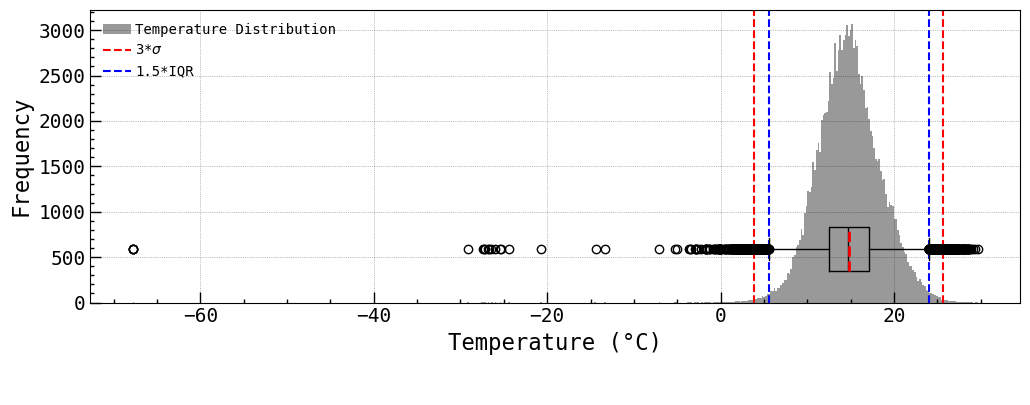

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df['temp_out'].plot.hist(bins=500, color='k', alpha=0.4, ax=ax, label="Temperature Distribution")

std = df['temp_out'].std()
mean = df['temp_out'].mean()
Q1 = df['temp_out'].quantile(0.25)
Q3 = df['temp_out'].quantile(0.75)
IQR = Q3 - Q1

ax.axvline(mean-(3*std), color='r', linestyle='--', label=r'3*$\sigma$')
ax.axvline(mean+(3*std), color='r', linestyle='--')

ax.axvline(Q1 - 1.5*IQR, color='b', linestyle='--', label='1.5*IQR')
ax.axvline(Q3 + 1.5*IQR, color='b', linestyle='--')

# add boxplot to histogram in the same plot horizontally
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", size="100%", pad=-2.0, sharex=ax)
df['temp_out'].plot.box(ax=ax2, vert=False, color='k', showmeans=True, meanline=True, meanprops=dict(color='r', linewidth=2))

ax2.axis('off')
ax.legend()
ax.set_xlabel("Temperature (°C)")

plt.savefig("./results/temperature_distribution_outliers.png", dpi=72, bbox_inches='tight', pad_inches=0.1)
plt.savefig("./results/temperature_distribution_outliers.pdf", dpi=150, bbox_inches='tight', pad_inches=0.1)


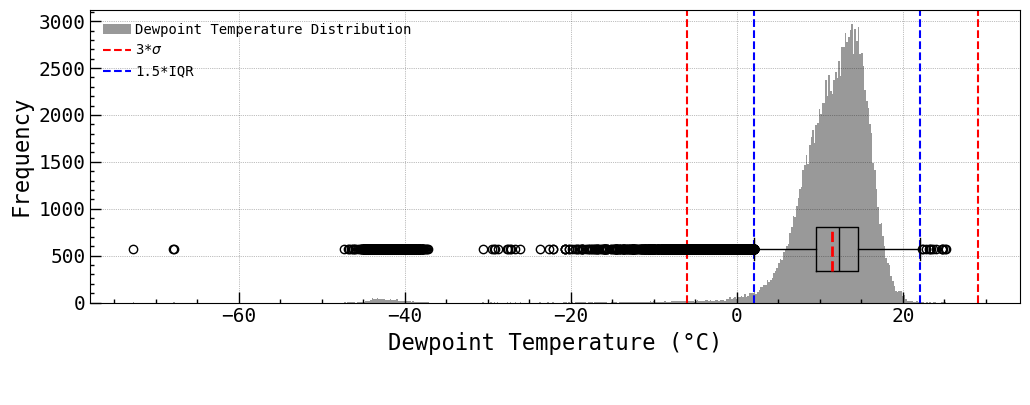

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df['dew_pt'].plot.hist(bins=500, color='k', alpha=0.4, ax=ax, label="Dewpoint Temperature Distribution")

std = df['dew_pt'].std()
mean = df['dew_pt'].mean()
Q1 = df['dew_pt'].quantile(0.25)
Q3 = df['dew_pt'].quantile(0.75)
IQR = Q3 - Q1

ax.axvline(mean-(3*std), color='r', linestyle='--', label=r'3*$\sigma$')
ax.axvline(mean+(3*std), color='r', linestyle='--')

ax.axvline(Q1 - 1.5*IQR, color='b', linestyle='--', label='1.5*IQR')
ax.axvline(Q3 + 1.5*IQR, color='b', linestyle='--')

# add boxplot to histogram in the same plot horizontally
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", size="100%", pad=-2.0, sharex=ax)
df['dew_pt'].plot.box(ax=ax2, vert=False, color='k', showmeans=True, meanline=True, meanprops=dict(color='r', linewidth=2))

ax2.axis('off')
ax.legend()
ax.set_xlabel("Dewpoint Temperature (°C)")

plt.savefig("./results/dewpoint_temperature_distribution_outliers.png", dpi=72, bbox_inches='tight', pad_inches=0.1)
plt.savefig("./results/dewpoint_temperature_distribution_outliers.pdf", dpi=150, bbox_inches='tight', pad_inches=0.1)


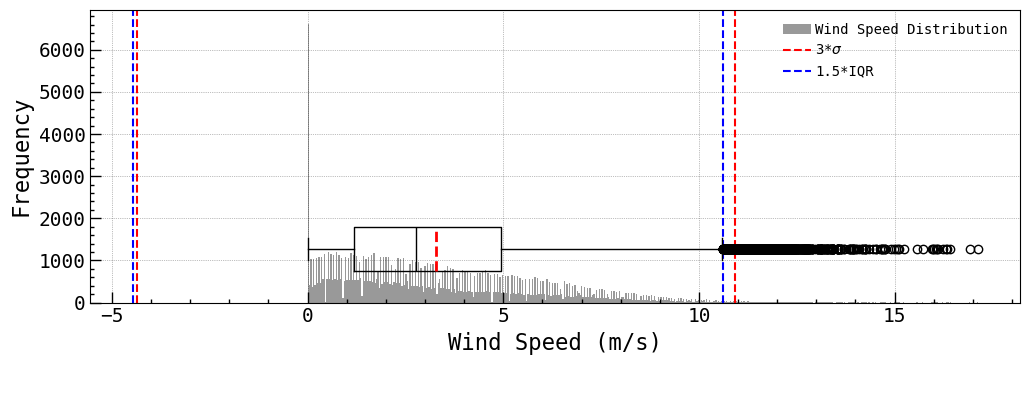

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df['wind_speed'].plot.hist(bins=500, color='k', alpha=0.4, ax=ax, label="Wind Speed Distribution")

std = df['wind_speed'].std()
mean = df['wind_speed'].mean()
Q1 = df['wind_speed'].quantile(0.25)
Q3 = df['wind_speed'].quantile(0.75)
IQR = Q3 - Q1

ax.axvline(mean-(3*std), color='r', linestyle='--', label=r'3*$\sigma$')
ax.axvline(mean+(3*std), color='r', linestyle='--')

ax.axvline(Q1 - 1.5*IQR, color='b', linestyle='--', label='1.5*IQR')
ax.axvline(Q3 + 1.5*IQR, color='b', linestyle='--')

# add boxplot to histogram in the same plot horizontally
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", size="100%", pad=-2.0, sharex=ax)
df['wind_speed'].plot.box(ax=ax2, vert=False, color='k', showmeans=True, meanline=True, meanprops=dict(color='r', linewidth=2))

ax2.axis('off')
ax.legend()
ax.set_xlabel("Wind Speed (m/s)")

plt.savefig("./results/wind_speed_distribution_outliers.png", dpi=72, bbox_inches='tight', pad_inches=0.1)
plt.savefig("./results/wind_speed_distribution_outliers.pdf", dpi=150, bbox_inches='tight', pad_inches=0.1)


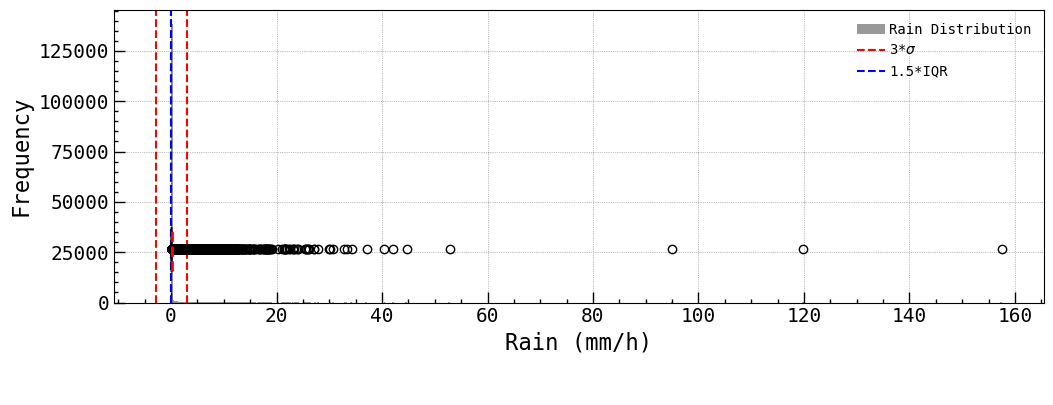

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df['rain'].plot.hist(bins=500, color='k', alpha=0.4, ax=ax, label="Rain Distribution")

std = df['rain'].std()
mean = df['rain'].mean()
Q1 = df['rain'].quantile(0.25)
Q3 = df['rain'].quantile(0.75)
IQR = Q3 - Q1

ax.axvline(mean-(3*std), color='r', linestyle='--', label=r'3*$\sigma$')
ax.axvline(mean+(3*std), color='r', linestyle='--')

ax.axvline(Q1 - 1.5*IQR, color='b', linestyle='--', label='1.5*IQR')
ax.axvline(Q3 + 1.5*IQR, color='b', linestyle='--')

# add boxplot to histogram in the same plot horizontally
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", size="100%", pad=-2.0, sharex=ax)
df['rain'].plot.box(ax=ax2, vert=False, color='k', showmeans=True, meanline=True, meanprops=dict(color='r', linewidth=2))

ax2.axis('off')
ax.legend()
ax.set_xlabel("Rain (mm/h)")

plt.savefig("./results/rain_distribution_outliers.png", dpi=72, bbox_inches='tight', pad_inches=0.1)
plt.savefig("./results/rain_distribution_outliers.pdf", dpi=150, bbox_inches='tight', pad_inches=0.1)


In [33]:
# remove outliers based on the 3 sigma rule
def remove_outliers(df, column):
    return df[np.abs(df[column] - df[column].mean()) <= (3 * df[column].std())]

# reomve outliers IQR rule
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

/tmp/ipykernel_256048/4242067931.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=[variable], inplace=True)


temp_out - Day: 68461 - Night: 57301


/tmp/ipykernel_256048/4242067931.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=[variable], inplace=True)


dew_pt - Day: 68040 - Night: 57001


/tmp/ipykernel_256048/4242067931.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=[variable], inplace=True)


wind_speed - Day: 69349 - Night: 58657


/tmp/ipykernel_256048/4242067931.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=[variable], inplace=True)


rain - Day: 76989 - Night: 65193


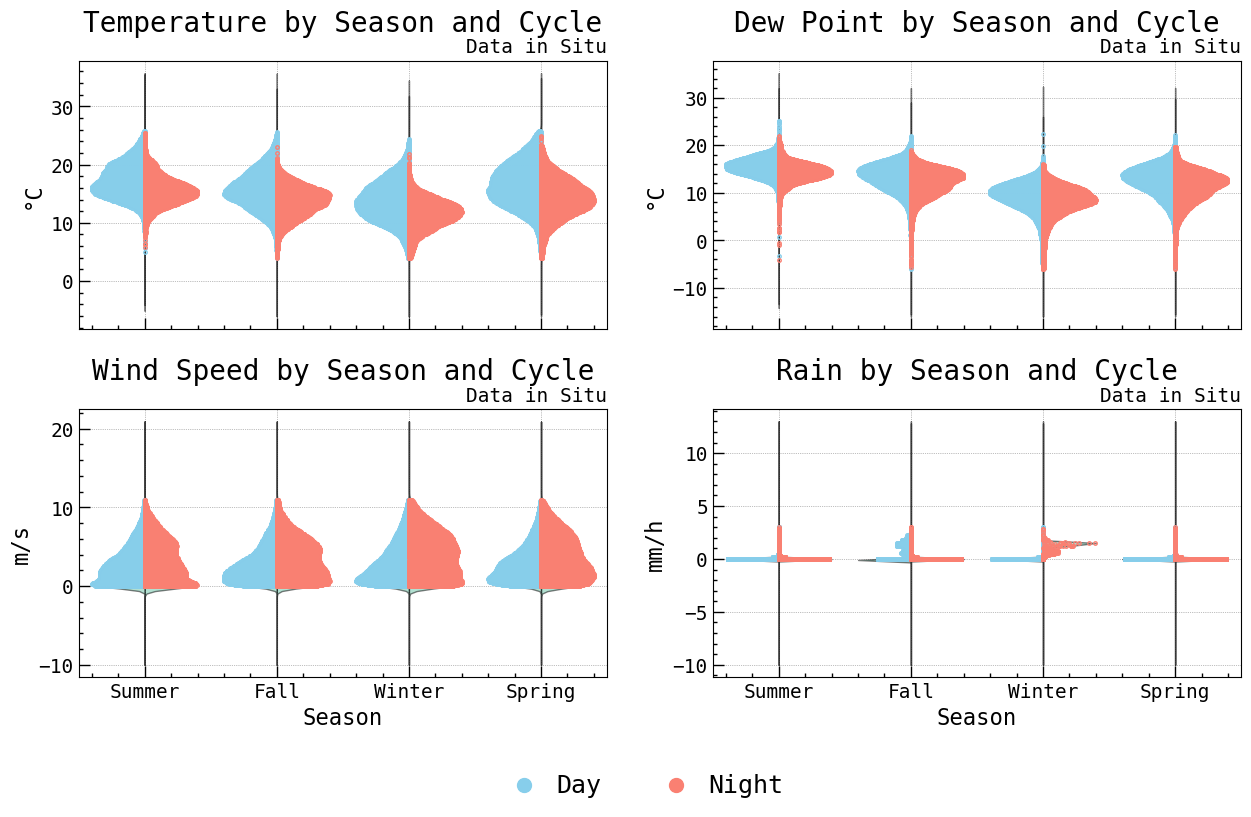

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

variables = ['temp_out', 'dew_pt', 'wind_speed', 'rain']
vlabels = ['Temperature', 'Dew Point', 'Wind Speed', 'Rain']
seasons = ['Summer', 'Fall', 'Winter', 'Spring']
vunits = ['°C', '°C', 'm/s', 'mm/h']
colors_cycle = ['skyblue', 'salmon']
plot_opts = {
    'bean_show_mean': False, 
    'bean_show_median': False, 
    'cutoff_val': 10, 
    'cutoff_type': 'abs', 
    'jitter_marker':'.',
    'jitter_marker_size': 5,
    'bean_legend_text': None
}

for i, variable in enumerate(variables):
    ax = axs.flat[i]
    # Preparando os dados para os ciclos diurnos e noturnos
    new_df = remove_outliers(df, variable)
    new_df.dropna(subset=[variable], inplace=True)
    day_data = new_df[new_df['cycle'] == 'day']
    night_data = new_df[new_df['cycle'] == 'night']

    print(f"{variable} - Day: {len(day_data)} - Night: {len(night_data)}")

    day_values = [day_data[day_data['season'] == season][variable].dropna().values for season in ['Summer', 'Fall', 'Winter', 'Spring']]
    night_values = [night_data[night_data['season'] == season][variable].dropna().values for season in ['Summer', 'Fall', 'Winter', 'Spring']]

    # Certifique-se de que cada lista tenha múltiplos elementos
    day_values = [vals for vals in day_values if len(vals) > 1]
    night_values = [vals for vals in night_values if len(vals) > 1]

    # Plotar dados do ciclo diurno no lado esquerdo
    plot_opts['bean_color'] = 'skyblue' 
    # plot_opts['bean_legend_text'] = 'Day'
    if day_values:
        sm.graphics.beanplot(day_values, ax=ax, labels=seasons[:len(day_values)], side='left', jitter=True, plot_opts=plot_opts)

    # Plotar dados do ciclo noturno no lado direito
    plot_opts['bean_color'] = 'salmon'
    # plot_opts['bean_legend_text'] = 'Night'
    if night_values:
        sm.graphics.beanplot(night_values, ax=ax, labels=seasons[:len(night_values)], side='right', jitter=True, plot_opts=plot_opts)

    ax.set_title(f"{vlabels[i]} by Season and Cycle", y=1.08)
    ax.set_title("Data in Situ", loc='right', fontsize=14)
    ax.set_ylabel(vunits[i])
    if i > 1:
        ax.set_xlabel('Season')
    # break


plt.subplots_adjust(hspace=0.3)

# add legend below subplots center
ax2 = fig.add_axes([0.35, -0.05, 0.3, 0.05])
ax2.axis('off')
ax2.scatter([], [], color='skyblue', label='Day', s=100)
ax2.scatter([], [], color='salmon', label='Night', s=100)
ax2.legend(loc='center', ncol=2, fontsize=18)


    
plt.savefig('./results/InSitu_Season_and_Cycle.png', dpi=72, bbox_inches='tight')
plt.savefig('./results/InSitu_Season_and_Cycle.pdf', dpi=150, bbox_inches='tight')


In [47]:
def p25(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 25)

def p50(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 50)

def p75(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 75)

def p90(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 90)

def p95(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 95)

def p99(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 99)

stats_day = pd.DataFrame()

columns = [
    'temp_out_mean', 'temp_out_max', 'temp_out_min', 'temp_out_p25', 'temp_out_p50', 'temp_out_p75', 'temp_out_p90', 'temp_out_p95', 'temp_out_p99',
    'dew_pt_mean', 'dew_pt_max', 'dew_pt_min', 'dew_pt_p25', 'dew_pt_p50', 'dew_pt_p75', 'dew_pt_p90', 'dew_pt_p95', 'dew_pt_p99',
    'wind_speed_mean', 'wind_speed_max', 'wind_speed_min', 'wind_speed_p25', 'wind_speed_p50', 'wind_speed_p75', 'wind_speed_p90', 'wind_speed_p95', 'wind_speed_p99',
    'rain_sum', 'rain_max', 'rain_min', 'rain_p25', 'rain_p50', 'rain_p75', 'rain_p90', 'rain_p95', 'rain_p99'
]

var_outliers = ['temp_out', 'dew_pt', 'wind_speed', 'rain']
for variable in var_outliers:
    df_aux = df[df['cycle'] == 'day']
    df_aux = remove_outliers(df_aux, variable)
    
    if variable == 'rain':
        stats_day[f'{variable}_sum'] = df_aux.groupby('season')[variable].sum()
    else:
        stats_day[f'{variable}_mean'] = df_aux.groupby('season')[variable].mean()
    stats_day[f'{variable}_max'] = df_aux.groupby('season')[variable].max()
    stats_day[f'{variable}_min'] = df_aux.groupby('season')[variable].min()
    stats_day[f'{variable}_p25'] = df_aux.groupby('season')[variable].apply(p25)
    stats_day[f'{variable}_p50'] = df_aux.groupby('season')[variable].apply(p50)
    stats_day[f'{variable}_p75'] = df_aux.groupby('season')[variable].apply(p75)
    stats_day[f'{variable}_p90'] = df_aux.groupby('season')[variable].apply(p90)
    stats_day[f'{variable}_p95'] = df_aux.groupby('season')[variable].apply(p95)
    stats_day[f'{variable}_p99'] = df_aux.groupby('season')[variable].apply(p99)


stats_day.columns = columns
stats_day.T.to_csv('./results/InSitu_Seasonal_Day_Stats.csv')
stats_day

,temp_out_mean,temp_out_max,temp_out_min,temp_out_p25,temp_out_p50,temp_out_p75,temp_out_p90,temp_out_p95,temp_out_p99,dew_pt_mean,...,wind_speed_p99,rain_sum,rain_max,rain_min,rain_p25,rain_p50,rain_p75,rain_p90,rain_p95,rain_p99
season,,,,,,,,,,,,,,,,,,,,,
Fall,15.722421,26.183333,4.716667,13.600000,15.600000,17.850000,19.933333,21.127500,23.115500,13.356899,...,8.870370,713.28,3.31,0.0,0.0,0.0,0.0,0.0,0.00,1.26
Spring,16.667169,26.850000,4.716667,13.991667,16.550000,19.316667,21.597500,22.936250,25.103917,12.558259,...,8.944444,974.17,3.31,0.0,0.0,0.0,0.0,0.0,0.25,1.51
Summer,17.370496,26.858333,4.916667,15.200000,17.083333,19.450000,21.300000,22.425833,24.461833,15.497043,...,8.710162,1101.85,3.31,0.0,0.0,0.0,0.0,0.0,0.25,1.77
Winter,13.766005,24.433333,4.716667,11.400000,13.650000,16.083333,18.200000,19.300000,21.340917,9.262677,...,9.203704,324.52,3.30,0.0,0.0,0.0,0.0,0.0,0.00,0.50


In [48]:
def p25(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 25)

def p50(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 50)

def p75(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 75)

def p90(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 90)

def p95(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 95)

def p99(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 99)

stats_night = pd.DataFrame()

columns = [
    'temp_out_mean', 'temp_out_max', 'temp_out_min', 'temp_out_p25', 'temp_out_p50', 'temp_out_p75', 'temp_out_p90', 'temp_out_p95', 'temp_out_p99',
    'dew_pt_mean', 'dew_pt_max', 'dew_pt_min', 'dew_pt_p25', 'dew_pt_p50', 'dew_pt_p75', 'dew_pt_p90', 'dew_pt_p95', 'dew_pt_p99',
    'wind_speed_mean', 'wind_speed_max', 'wind_speed_min', 'wind_speed_p25', 'wind_speed_p50', 'wind_speed_p75', 'wind_speed_p90', 'wind_speed_p95', 'wind_speed_p99',
    'rain_sum', 'rain_max', 'rain_min', 'rain_p25', 'rain_p50', 'rain_p75', 'rain_p90', 'rain_p95', 'rain_p99'
]

var_outliers = ['temp_out', 'dew_pt', 'wind_speed', 'rain']
for variable in var_outliers:
    df_aux = df[df['cycle'] == 'day']
    df_aux = remove_outliers(df_aux, variable)
    
    if variable == 'rain':
        stats_night[f'{variable}_sum'] = df_aux.groupby('season')[variable].sum()
    else:
        stats_night[f'{variable}_mean'] = df_aux.groupby('season')[variable].mean()
    stats_night[f'{variable}_max'] = df_aux.groupby('season')[variable].max()
    stats_night[f'{variable}_min'] = df_aux.groupby('season')[variable].min()
    stats_night[f'{variable}_p25'] = df_aux.groupby('season')[variable].apply(p25)
    stats_night[f'{variable}_p50'] = df_aux.groupby('season')[variable].apply(p50)
    stats_night[f'{variable}_p75'] = df_aux.groupby('season')[variable].apply(p75)
    stats_night[f'{variable}_p90'] = df_aux.groupby('season')[variable].apply(p90)
    stats_night[f'{variable}_p95'] = df_aux.groupby('season')[variable].apply(p95)
    stats_night[f'{variable}_p99'] = df_aux.groupby('season')[variable].apply(p99)

stats_night.columns = columns
stats_night.T.to_csv('./results/InSitu_Seasonal_Night_Stats.csv')
stats_night

,temp_out_mean,temp_out_max,temp_out_min,temp_out_p25,temp_out_p50,temp_out_p75,temp_out_p90,temp_out_p95,temp_out_p99,dew_pt_mean,...,wind_speed_p99,rain_sum,rain_max,rain_min,rain_p25,rain_p50,rain_p75,rain_p90,rain_p95,rain_p99
season,,,,,,,,,,,,,,,,,,,,,
Fall,15.722421,26.183333,4.716667,13.600000,15.600000,17.850000,19.933333,21.127500,23.115500,13.356899,...,8.870370,713.28,3.31,0.0,0.0,0.0,0.0,0.0,0.00,1.26
Spring,16.667169,26.850000,4.716667,13.991667,16.550000,19.316667,21.597500,22.936250,25.103917,12.558259,...,8.944444,974.17,3.31,0.0,0.0,0.0,0.0,0.0,0.25,1.51
Summer,17.370496,26.858333,4.916667,15.200000,17.083333,19.450000,21.300000,22.425833,24.461833,15.497043,...,8.710162,1101.85,3.31,0.0,0.0,0.0,0.0,0.0,0.25,1.77
Winter,13.766005,24.433333,4.716667,11.400000,13.650000,16.083333,18.200000,19.300000,21.340917,9.262677,...,9.203704,324.52,3.30,0.0,0.0,0.0,0.0,0.0,0.00,0.50
